In [46]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Dataset Class

In [47]:
class EEGWindowDataset(Dataset):
    """
    Dataset for CNN-LSTM EEG temporal classification.
    Each sample:
    - X: (channels, time)
    - y: {0,1} → Short, Mid
    """
    def __init__(self, X_path, y_path):
        self.X = torch.tensor(np.load(X_path), dtype=torch.float32)
        self.y = torch.tensor(np.load(y_path), dtype=torch.long)

        assert len(self.X) == len(self.y), "X and y length mismatch"

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### Hybrid Architecture (CNN + LSTM)

In [48]:
class BrainDepthClassifier(nn.Module):
    """
    CNN-LSTM for EEG temporal depth classification.
    Input: (batch, channels, time)
    Output: (batch, 2) → Short / Mid
    """
    def __init__(self, n_channels, n_classes=2):
        super().__init__()

        # -------- CNN --------
        self.cnn = nn.Sequential(
            nn.Conv1d(n_channels, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.MaxPool1d(kernel_size=2)
        )

        # -------- LSTM --------
        self.lstm = nn.LSTM(
            input_size=64,
            hidden_size=128,
            batch_first=True
        )

        # -------- Classifier --------
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        x = self.cnn(x)              # (B, 64, T')
        x = x.permute(0, 2, 1)       # (B, T', 64)

        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]       # last timestep

        return self.classifier(x)

### Generate Visualizations

In [49]:
def plot_performance(history, true_labels, pred_labels):
    # ---- Learning Curves ----
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['t_loss'], label='Train Loss')
    plt.plot(history['v_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['t_acc'], label='Train Acc')
    plt.plot(history['v_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # ---- Confusion Matrix ----
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Short', 'Mid'],
        yticklabels=['Short', 'Mid']
    )
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

### TRAINING AND EVALUATION

In [50]:
def train_model(X_path, y_path, epochs=50, batch_size=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Executing on: {device}")

    # ---- Dataset ----
    full_dataset = EEGWindowDataset(X_path, y_path)
    indices = np.arange(len(full_dataset))
    y_all = full_dataset.y.numpy()

    train_idx, val_idx = train_test_split(
        indices,
        test_size=0.3,
        random_state=42,
        stratify=y_all
    )

    train_loader = DataLoader(
        Subset(full_dataset, train_idx),
        batch_size=batch_size,
        shuffle=True
    )

    val_loader = DataLoader(
        Subset(full_dataset, val_idx),
        batch_size=batch_size,
        shuffle=False
    )

    # ---- Model ----
    model = BrainDepthClassifier(
        n_channels=full_dataset.X.shape[1],
        n_classes=2
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    history = {'t_loss': [], 'v_loss': [], 't_acc': [], 'v_acc': []}

    # ---- Training Loop ----
    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += y.size(0)
            correct += (preds == y).sum().item()

        # ---- Validation ----
        model.eval()
        val_loss, v_correct, v_total = 0.0, 0, 0
        all_preds, all_true = [], []

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)

                v_total += y.size(0)
                v_correct += (preds == y).sum().item()

                all_preds.extend(preds.cpu().numpy())
                all_true.extend(y.cpu().numpy())

        history['t_loss'].append(train_loss / len(train_loader))
        history['v_loss'].append(val_loss / len(val_loader))
        history['t_acc'].append(100 * correct / total)
        history['v_acc'].append(100 * v_correct / v_total)

        print(
            f"Epoch [{epoch+1}/{epochs}] "
            f"| Train Acc: {history['t_acc'][-1]:.2f}% "
            f"| Val Acc: {history['v_acc'][-1]:.2f}%"
        )

    torch.save(model.state_dict(), "braindepth_final_model.pth")
    plot_performance(history, all_true, all_preds)

    return model, history

Executing on: cuda
Epoch [1/50] | Train Acc: 69.14% | Val Acc: 76.44%
Epoch [2/50] | Train Acc: 76.35% | Val Acc: 76.44%
Epoch [3/50] | Train Acc: 76.35% | Val Acc: 76.44%
Epoch [4/50] | Train Acc: 76.80% | Val Acc: 75.39%
Epoch [5/50] | Train Acc: 79.95% | Val Acc: 71.73%
Epoch [6/50] | Train Acc: 84.23% | Val Acc: 71.73%
Epoch [7/50] | Train Acc: 88.06% | Val Acc: 70.68%
Epoch [8/50] | Train Acc: 89.64% | Val Acc: 68.06%
Epoch [9/50] | Train Acc: 90.99% | Val Acc: 70.68%
Epoch [10/50] | Train Acc: 92.34% | Val Acc: 70.16%
Epoch [11/50] | Train Acc: 95.05% | Val Acc: 64.40%
Epoch [12/50] | Train Acc: 91.67% | Val Acc: 76.44%
Epoch [13/50] | Train Acc: 93.47% | Val Acc: 70.68%
Epoch [14/50] | Train Acc: 97.30% | Val Acc: 72.77%
Epoch [15/50] | Train Acc: 97.97% | Val Acc: 66.49%
Epoch [16/50] | Train Acc: 97.30% | Val Acc: 72.25%
Epoch [17/50] | Train Acc: 99.10% | Val Acc: 71.73%
Epoch [18/50] | Train Acc: 98.65% | Val Acc: 71.73%
Epoch [19/50] | Train Acc: 98.42% | Val Acc: 71.20%
Ep

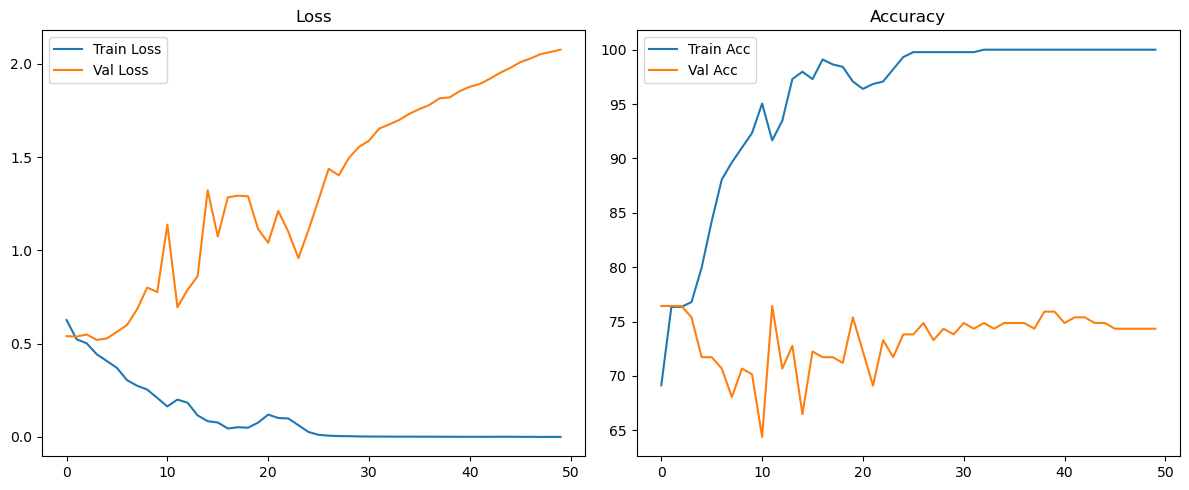

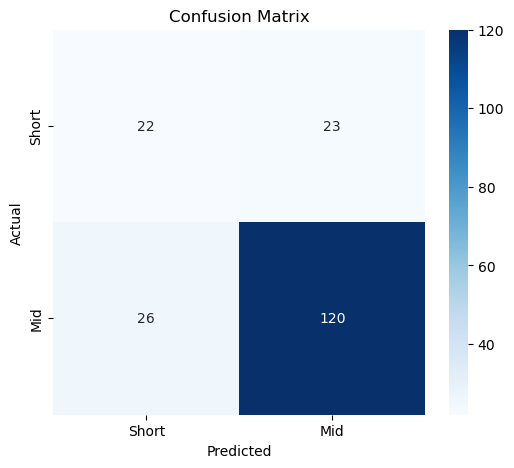

In [51]:
model, history = train_model(
    X_path="X_train.npy",
    y_path="y_train.npy",
    epochs=50,
    batch_size=32
)